In [1]:
import cv2
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import xml.etree.ElementTree as ET
from torch.utils.data import Dataset, DataLoader
import os
from sklearn.model_selection import train_test_split
import torch
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm


In [2]:
os.chdir(r"C:\Users\Lucas\Desktop\vacantion classes\Yolo project")
from classes.CNN_pytorch import YoloDataset, YoloLoss, YOLOv1, CNN_model, YOLO_visual #import my class CNN

In [3]:
os.chdir(r"C:\Users\Lucas\Desktop\vacantion classes\Yolo project\data\Pascal_VOC\train")

In [4]:
path = r"C:\Users\Lucas\Desktop\vacantion classes\Yolo project\data\Pascal_VOC\train"

xml_list = []
for filename in os.listdir(path):
    if not filename.endswith('.xml'): continue
    fullname = os.path.join(path, filename)
    xml_list.append(fullname)

In [5]:
my_CNN = CNN_model()
my_CNN.get_annotation(xml_list)
my_CNN.encode_pictures()

In [6]:
os.chdir(r"C:\Users\Lucas\Desktop\vacantion classes\Yolo project")
my_CNN.df.to_json(r"data\annot_df.json",orient="records")
torch.save(my_CNN.encoded_picture_annot, r"data\encoded_picture.pt")

In [7]:
df_encoded = torch.load(r"data\encoded_picture.pt",weights_only=False)
df_encoded

,file_name,encoded_grid
1,C:\Users\Lucas\Desktop\vacantion classes\Yolo ...,"[[[tensor(0.), tensor(0.), tensor(0.), tensor(..."
2,C:\Users\Lucas\Desktop\vacantion classes\Yolo ...,"[[[tensor(0.), tensor(0.), tensor(0.), tensor(..."
3,C:\Users\Lucas\Desktop\vacantion classes\Yolo ...,"[[[tensor(0.), tensor(0.), tensor(0.), tensor(..."
4,C:\Users\Lucas\Desktop\vacantion classes\Yolo ...,"[[[tensor(0.), tensor(0.), tensor(0.), tensor(..."
5,C:\Users\Lucas\Desktop\vacantion classes\Yolo ...,"[[[tensor(0.), tensor(0.), tensor(0.), tensor(..."
...,...,...
13295,C:\Users\Lucas\Desktop\vacantion classes\Yolo ...,"[[[tensor(0.), tensor(0.), tensor(0.), tensor(..."
13296,C:\Users\Lucas\Desktop\vacantion classes\Yolo ...,"[[[tensor(0.), tensor(0.), tensor(0.), tensor(..."
13297,C:\Users\Lucas\Desktop\vacantion classes\Yolo ...,"[[[tensor(0.), tensor(0.), tensor(0.), tensor(..."
13298,C:\Users\Lucas\Desktop\vacantion classes\Yolo ...,"[[[tensor(0.), tensor(0.), tensor(0.), tensor(..."


In [8]:
X_train, X_test, y_train, y_test = train_test_split(df_encoded['file_name'],df_encoded['encoded_grid'],test_size=0.4)

X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

In [9]:
X_train = X_train[:1000]
y_train = y_train[:1000]

In [10]:
train_dataset = YoloDataset(X_train, y_train)
test_dataset = YoloDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)


Epoch 1/70:   0%|          | 0/125 [00:00<?, ?it/s]

Starting training on cuda for 70 epochs...



c:\Users\Lucas\Desktop\vacantion classes\Yolo project\classes\CNN_pytorch.py:533: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(self.Y_tensor[idx], dtype=torch.float32)
Epoch 2/70:   0%|          | 0/125 [00:00<?, ?it/s]                        

Epoch [1/70] | Avg Loss: 8.4938


Epoch 3/70:   0%|          | 0/125 [00:00<?, ?it/s]                        

Epoch [2/70] | Avg Loss: 5.8743


Epoch 4/70:   0%|          | 0/125 [00:00<?, ?it/s]                       

Epoch [3/70] | Avg Loss: 5.5778


Epoch 5/70:   0%|          | 0/125 [00:00<?, ?it/s]                       

Epoch [4/70] | Avg Loss: 5.3576


Epoch 6/70:   0%|          | 0/125 [00:00<?, ?it/s]                       

Epoch [5/70] | Avg Loss: 5.1848


Epoch 7/70:   0%|          | 0/125 [00:00<?, ?it/s]                       

Epoch [6/70] | Avg Loss: 4.9502


Epoch 8/70:   0%|          | 0/125 [00:00<?, ?it/s]                        

Epoch [7/70] | Avg Loss: 4.9498


Epoch 9/70:   0%|          | 0/125 [00:00<?, ?it/s]                       

Epoch [8/70] | Avg Loss: 4.8085


Epoch 10/70:   0%|          | 0/125 [00:00<?, ?it/s]                      

Epoch [9/70] | Avg Loss: 4.8397


Epoch 11/70:   0%|          | 0/125 [00:00<?, ?it/s]                       

Epoch [10/70] | Avg Loss: 4.7885


Epoch 12/70:   0%|          | 0/125 [00:00<?, ?it/s]                       

Epoch [11/70] | Avg Loss: 4.8014


Epoch 13/70:   0%|          | 0/125 [00:00<?, ?it/s]                        

Epoch [12/70] | Avg Loss: 4.7414


Epoch 14/70:   0%|          | 0/125 [00:00<?, ?it/s]                       

Epoch [13/70] | Avg Loss: 4.7332


Epoch 15/70:   0%|          | 0/125 [00:00<?, ?it/s]                       

Epoch [14/70] | Avg Loss: 4.7369


Epoch 16/70:   0%|          | 0/125 [00:00<?, ?it/s]                        

Epoch [15/70] | Avg Loss: 4.6572


Epoch 17/70:   0%|          | 0/125 [00:00<?, ?it/s]                       

Epoch [16/70] | Avg Loss: 4.6931


Epoch 18/70:   0%|          | 0/125 [00:00<?, ?it/s]                       

Epoch [17/70] | Avg Loss: 4.6491


Epoch 19/70:   0%|          | 0/125 [00:00<?, ?it/s]                       

Epoch [18/70] | Avg Loss: 4.7049


Epoch 20/70:   0%|          | 0/125 [00:00<?, ?it/s]                       

Epoch [19/70] | Avg Loss: 4.6248


Epoch 21/70:   0%|          | 0/125 [00:00<?, ?it/s]                       

Epoch [20/70] | Avg Loss: 4.6480


Epoch 22/70:   0%|          | 0/125 [00:00<?, ?it/s]                       

Epoch [21/70] | Avg Loss: 4.6747


Epoch 23/70:   0%|          | 0/125 [00:00<?, ?it/s]                       

Epoch [22/70] | Avg Loss: 4.7545


Epoch 24/70:   0%|          | 0/125 [00:00<?, ?it/s]                       

Epoch [23/70] | Avg Loss: 4.6177


Epoch 25/70:   0%|          | 0/125 [00:00<?, ?it/s]                       

Epoch [24/70] | Avg Loss: 4.6418


Epoch 26/70:   0%|          | 0/125 [00:00<?, ?it/s]                       

Epoch [25/70] | Avg Loss: 4.6369


Epoch 27/70:   0%|          | 0/125 [00:00<?, ?it/s]                       

Epoch [26/70] | Avg Loss: 4.5934


Epoch 28/70:   0%|          | 0/125 [00:00<?, ?it/s]                       

Epoch [27/70] | Avg Loss: 4.5927


Epoch 29/70:   0%|          | 0/125 [00:00<?, ?it/s]                       

Epoch [28/70] | Avg Loss: 4.6070


Epoch 30/70:   0%|          | 0/125 [00:00<?, ?it/s]                       

Epoch [29/70] | Avg Loss: 4.6348


Epoch 31/70:   0%|          | 0/125 [00:00<?, ?it/s]                       

Epoch [30/70] | Avg Loss: 4.6539


Epoch 32/70:   0%|          | 0/125 [00:00<?, ?it/s]                       

Epoch [31/70] | Avg Loss: 4.6102


Epoch 33/70:   0%|          | 0/125 [00:00<?, ?it/s]                       

Epoch [32/70] | Avg Loss: 4.5241


Epoch 34/70:   0%|          | 0/125 [00:00<?, ?it/s]                       

Epoch [33/70] | Avg Loss: 4.5512


Epoch 35/70:   0%|          | 0/125 [00:00<?, ?it/s]                       

Epoch [34/70] | Avg Loss: 4.5381


Epoch 36/70:   0%|          | 0/125 [00:00<?, ?it/s]                       

Epoch [35/70] | Avg Loss: 4.5655


Epoch 37/70:   0%|          | 0/125 [00:00<?, ?it/s]                       

Epoch [36/70] | Avg Loss: 4.5343


Epoch 38/70:   0%|          | 0/125 [00:00<?, ?it/s]                       

Epoch [37/70] | Avg Loss: 4.5612


Epoch 39/70:   0%|          | 0/125 [00:00<?, ?it/s]                        

Epoch [38/70] | Avg Loss: 4.5924


Epoch 40/70:   0%|          | 0/125 [00:00<?, ?it/s]                       

Epoch [39/70] | Avg Loss: 4.5628


Epoch 41/70:   0%|          | 0/125 [00:00<?, ?it/s]                       

Epoch [40/70] | Avg Loss: 4.5199


Epoch 42/70:   0%|          | 0/125 [00:00<?, ?it/s]                       

Epoch [41/70] | Avg Loss: 4.6378


Epoch 43/70:   0%|          | 0/125 [00:00<?, ?it/s]                       

Epoch [42/70] | Avg Loss: 4.5214


Epoch 44/70:   0%|          | 0/125 [00:00<?, ?it/s]                       

Epoch [43/70] | Avg Loss: 4.5849


Epoch 45/70:   0%|          | 0/125 [00:00<?, ?it/s]                       

Epoch [44/70] | Avg Loss: 4.5631


Epoch 46/70:   0%|          | 0/125 [00:00<?, ?it/s]                       

Epoch [45/70] | Avg Loss: 4.5523


Epoch 47/70:   0%|          | 0/125 [00:00<?, ?it/s]                       

Epoch [46/70] | Avg Loss: 4.4972


Epoch 48/70:   0%|          | 0/125 [00:00<?, ?it/s]                       

Epoch [47/70] | Avg Loss: 4.4921


Epoch 49/70:   0%|          | 0/125 [00:00<?, ?it/s]                       

Epoch [48/70] | Avg Loss: 4.5299


Epoch 50/70:   0%|          | 0/125 [00:00<?, ?it/s]                       

Epoch [49/70] | Avg Loss: 4.5168


Epoch 51/70:   0%|          | 0/125 [00:00<?, ?it/s]                       

Epoch [50/70] | Avg Loss: 4.5436


Epoch 52/70:   0%|          | 0/125 [00:00<?, ?it/s]                       

Epoch [51/70] | Avg Loss: 4.6126


Epoch 53/70:   0%|          | 0/125 [00:00<?, ?it/s]                        

Epoch [52/70] | Avg Loss: 4.5472


Epoch 54/70:   0%|          | 0/125 [00:00<?, ?it/s]                       

Epoch [53/70] | Avg Loss: 4.5370


Epoch 55/70:   0%|          | 0/125 [00:00<?, ?it/s]                       

Epoch [54/70] | Avg Loss: 4.5423


Epoch 56/70:   0%|          | 0/125 [00:00<?, ?it/s]                       

Epoch [55/70] | Avg Loss: 4.5216


Epoch 57/70:   0%|          | 0/125 [00:00<?, ?it/s]                       

Epoch [56/70] | Avg Loss: 4.5344


Epoch 58/70:   0%|          | 0/125 [00:00<?, ?it/s]                       

Epoch [57/70] | Avg Loss: 4.5256


Epoch 59/70:   0%|          | 0/125 [00:00<?, ?it/s]                       

Epoch [58/70] | Avg Loss: 4.5457


Epoch 60/70:   0%|          | 0/125 [00:00<?, ?it/s]                       

Epoch [59/70] | Avg Loss: 4.5007


Epoch 61/70:   0%|          | 0/125 [00:00<?, ?it/s]                       

Epoch [60/70] | Avg Loss: 4.5207


Epoch 62/70:   0%|          | 0/125 [00:00<?, ?it/s]                       

Epoch [61/70] | Avg Loss: 4.5530


Epoch 63/70:   0%|          | 0/125 [00:00<?, ?it/s]                       

Epoch [62/70] | Avg Loss: 4.5226


Epoch 64/70:   0%|          | 0/125 [00:00<?, ?it/s]                       

Epoch [63/70] | Avg Loss: 4.5807


Epoch 65/70:   0%|          | 0/125 [00:00<?, ?it/s]                       

Epoch [64/70] | Avg Loss: 4.4813


Epoch 66/70:   0%|          | 0/125 [00:00<?, ?it/s]                       

Epoch [65/70] | Avg Loss: 4.5163


Epoch 67/70:   0%|          | 0/125 [00:00<?, ?it/s]                       

Epoch [66/70] | Avg Loss: 4.5660


Epoch 68/70:   0%|          | 0/125 [00:00<?, ?it/s]                        

Epoch [67/70] | Avg Loss: 4.5232


Epoch 69/70:   0%|          | 0/125 [00:00<?, ?it/s]                       

Epoch [68/70] | Avg Loss: 4.6044


Epoch 70/70:   0%|          | 0/125 [00:00<?, ?it/s]                        

Epoch [69/70] | Avg Loss: 4.5473


Epoch [70/70] | Avg Loss: 4.4996

💾 Model saved as yolov1_trained.pth


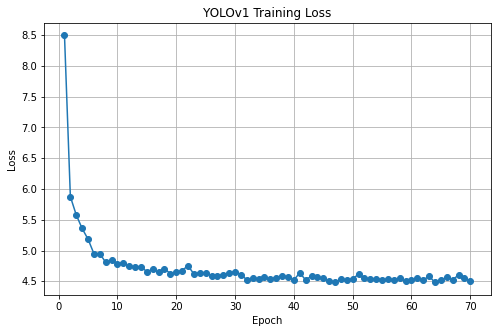

In [11]:
train_dataset = YoloDataset(X_train, y_train)
test_dataset = YoloDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

# -------------------------------
# 2️⃣ Initialize Model, Loss, Optimizer
# -------------------------------
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
S, B, C = 7, 2, 20

model = YOLOv1(S=S, B=B, C=C).to(device)
criterion = YoloLoss(S=S, B=B, C=C)
#optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
optimizer = torch.optim.SGD(model.parameters(),lr=1e-2,momentum=0.9,weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer,milestones=[75, 105],gamma=0.1)


# -------------------------------
# 3️⃣ Training Loop with Progress Bar
# -------------------------------
num_epochs = 70
train_losses = []

print(f"Starting training on {device} for {num_epochs} epochs...\n")

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False)

    for imgs, labels in progress_bar:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        preds = model(imgs)
        loss = criterion.yolo_loss(preds, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5)
        optimizer.step()

        running_loss += loss.item()
        progress_bar.set_postfix({"Loss": f"{loss.item():.4f}"})

    scheduler.step()
    avg_loss = running_loss / len(train_loader)
    train_losses.append(avg_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}] | Avg Loss: {avg_loss:.4f}")
    
torch.save(model.state_dict(), "yolov1_trained.pth")
print("\n💾 Model saved as yolov1_trained.pth")

# -------------------------------
# 4️⃣ Plot Training Loss Curve
# -------------------------------
plt.figure(figsize=(8,5))
plt.plot(range(1, num_epochs+1), train_losses, marker='o')
plt.title("YOLOv1 Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
S, B, C = 7, 2, 20

model = YOLOv1(S=S, B=B, C=C).to(device)
criterion = YoloLoss(S=S, B=B, C=C)
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)

loaded_model = YOLOv1(S=S, B=B, C=C).to(device)
loaded_model.load_state_dict(torch.load("yolov1_trained.pth", map_location=device))
loaded_model.eval()
print("🔁 Loaded model from yolov1_trained.pth")


🔁 Loaded model from yolov1_trained.pth


In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
S, B, C = 7, 2, 20

model = YOLOv1(S=S, B=B, C=C).to(device)
criterion = YoloLoss(S=S, B=B, C=C)
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)

loaded_model = YOLOv1(S=S, B=B, C=C).to(device)
loaded_model.load_state_dict(torch.load("yolov1_trained.pth", map_location=device))
loaded_model.eval()
print("🔁 Loaded model from yolov1_trained.pth")

# -------------------------------
# 7️⃣ Evaluate on Test Set
# -------------------------------
test_loss = 0.0
with torch.no_grad():
    for imgs, labels in tqdm(test_loader, desc="Evaluating"):
        imgs, labels = imgs.to(device), labels.to(device)
        preds = loaded_model(imgs)
        loss = criterion.yolo_loss(preds, labels)
        test_loss += loss.item()

avg_test_loss = test_loss / len(test_loader)
print(f"\n📊 Test Loss: {avg_test_loss:.4f}")

Evaluating:   0%|          | 0/665 [00:00<?, ?it/s]

🔁 Loaded model from yolov1_trained.pth


Evaluating: 100%|██████████| 665/665 [03:57<00:00,  2.80it/s]


📊 Test Loss: 4.3950


In [14]:
img_path = X_train[12]
img = cv2.imread(img_path)
img = cv2.resize(img, (448, 448))
img_rgb = img[..., ::-1] / 255.0
img_tensor = torch.tensor(img_rgb, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0).to(device)

with torch.no_grad():
    pred = model(img_tensor)[0]  # shape: [S, S, C+B*5]
    print(pred[0,0])

tensor([ 0.0039,  0.0107, -0.0125,  0.0057,  0.0140, -0.0157, -0.0004, -0.0080,
         0.0080,  0.0118, -0.0045,  0.0154,  0.0075,  0.0154,  0.0081,  0.0075,
         0.0147,  0.0047,  0.0026,  0.0017,  0.0130,  0.0104,  0.0089, -0.0078,
         0.0028, -0.0100,  0.0089, -0.0139,  0.0124, -0.0084], device='cuda:0')


In [31]:
img_path = X_train[0]
print(img_path)
my_visual = YOLO_visual(S=S, B=B, C=C, classes=my_CNN.classes)

my_visual.Yolo_visualize(loaded_model,img_path,device="cuda",score_threshold=0.03)

C:\Users\Lucas\Desktop\vacantion classes\Yolo project\data\Pascal_VOC\train\2011_002786_jpg.rf.d69099695917fc156367535e3e05c5ca.jpg
[0.04952029 0.0495837  0.04845295 0.04922765 0.04915128 0.04866567
 0.04818825 0.04877037 0.0498607  0.04894486 0.05584998 0.04878722
 0.04863393 0.04872508 0.05027661 0.05466686 0.04976331 0.04969248
 0.05443043 0.04880843]
[0.0484092  0.05441841 0.05461612 0.0481525  0.0486705  0.04855382
 0.04864991 0.04907081 0.0480144  0.04944605 0.04749207 0.04830261
 0.0569487  0.04783904 0.04820745 0.05804725 0.04858441 0.04940245
 0.04817442 0.04899993]
[0.04942239 0.05516328 0.04935839 0.04955345 0.04879647 0.04895357
 0.04857758 0.04906705 0.05004669 0.04909982 0.04741395 0.04894309
 0.04922385 0.04952409 0.05487964 0.04891557 0.04869014 0.04953146
 0.05536834 0.04947106]
[0.04905301 0.0622039  0.04872221 0.04822597 0.04925796 0.05472119
 0.04847424 0.05311945 0.04960485 0.04933281 0.04845456 0.04812172
 0.04750478 0.04931068 0.04839828 0.04748798 0.04748728 0.0

In [16]:
y_train[0][3][3]

tensor([1.0000, 0.1990, 0.5110, 0.6180, 0.9969, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000])

In [17]:
img_path = X_train[0]
img = cv2.imread(img_path)
img = cv2.resize(img, (448, 448))
img_rgb = img[..., ::-1] / 255.0
img_tensor = torch.tensor(img_rgb, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0).to(device)

In [18]:
predict = model(img_tensor)
predict[:,3,3]

tensor([[ 0.0111,  0.0098, -0.0047,  0.0067,  0.0030,  0.0104, -0.0002,  0.0100,
          0.0118,  0.0143, -0.0162, -0.0065,  0.0088, -0.0187, -0.0124,  0.0005,
          0.0017, -0.0113, -0.0066,  0.0017, -0.0103, -0.0088,  0.0100,  0.0144,
         -0.0058, -0.0009, -0.0081,  0.0121, -0.0150,  0.0122]],
       device='cuda:0', grad_fn=<SelectBackward0>)